# Importing libraries and modules

In [1]:
import os
import csv
import pickle
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_sequence, pack_padded_sequence

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

/Users/Kuba/miniforge3/envs/SSNE/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Helper functions

In [2]:
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

In [3]:
def get_device():
    """Returns the available device for computation.
    Returns:
        torch.device: available device for computation
    """
    compute_device = None
    if torch.cuda.is_available():
        compute_device = torch.device('cuda')
    elif torch.backends.mps.is_available():
        compute_device = torch.device('mps')
    else:
        compute_device = torch.device('cpu')
    
    print(f'device is {compute_device}')
    return compute_device


def save_predictions_to_csv(predictions, file_path):
    with open(file_path, "w") as f:
        writer = csv.writer(f)
        writer.writerows(predictions.items())
        

def save_to_csv(numpy_array: np.ndarray, filename: str):
    np.savetxt(filename, numpy_array, delimiter=",", fmt='%1d')

# Params and constants

In [4]:
random_seed = 100
device = get_device()
# device = torch.device('cpu')

VAL_SET_FRACTION = 0.10

class_names = {0: 'bach', 1: 'beethoven', 2: 'debussy', 3: 'scarlatti', 4: 'victoria'}

train_data_path = 'train.pkl'
test_data_opath = 'test_no_target.pkl'

device is mps


In [5]:
torch.manual_seed(random_seed)
np.random.seed(random_seed)

# Loading data

In [6]:
with open(train_data_path, 'rb') as pickle_file:
    data = np.array(pickle.load(pickle_file), dtype=object)

In [7]:
samples, labels = data[:, 0], data[:, 1]

samples.shape, labels.shape 

((2939,), (2939,))

In [8]:
X = []
y = []

for sample, label in zip(samples, labels):
    X.append(torch.from_numpy(sample).type(torch.float32)) # TODO convert to double
    y.append(label)

y = torch.Tensor(y).type(torch.LongTensor).view(-1, 1)

In [9]:
assert len(X) == len(y)

In [10]:
num_classes = len(np.unique(y))
num_classes

5

# EDA

### Sample values distribution

In [11]:
X_sum = torch.concat(X)

In [12]:
X_sum.min(), X_sum.max()

(tensor(-1.), tensor(191.))

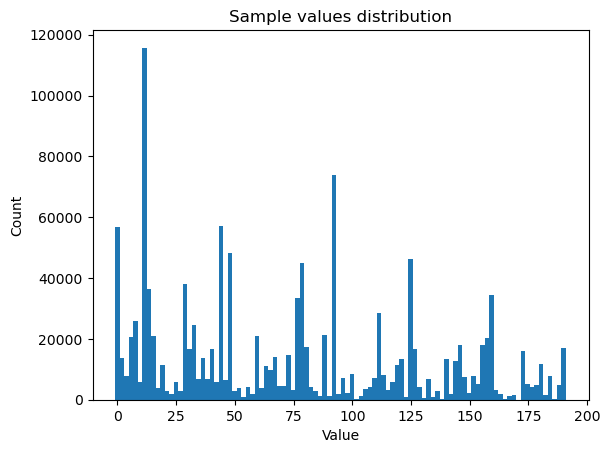

In [13]:
plt.hist(X_sum, bins=100)

plt.title('Sample values distribution')
plt.ylabel('Count')
plt.xlabel('Value')

plt.show()

We have some negative, and zero values. The min value is -1. Let's make all sample values positive, by adding 2 to each sample.

In [14]:
X = [sample + 2 for sample in X]

In [15]:
X_sum = torch.concat(X)

In [16]:
X_sum.min(), X_sum.max()

(tensor(1.), tensor(193.))

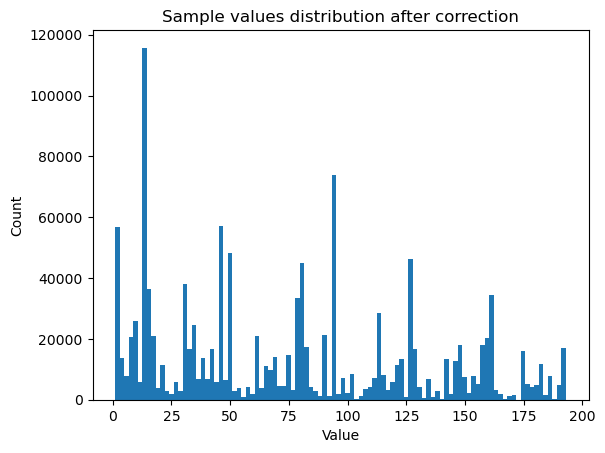

In [17]:
plt.hist(X_sum, bins=100)

plt.title('Sample values distribution after correction')
plt.ylabel('Count')
plt.xlabel('Value')

plt.show()

### Sample length

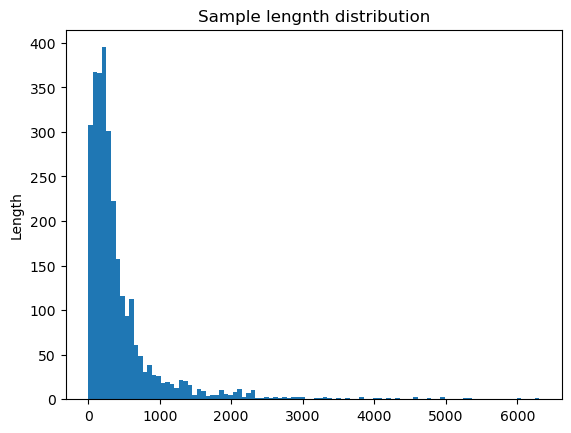

In [18]:
plt.hist(list(map(lambda x: len(x), X)), bins=100)

plt.title('Sample lengnth distribution')
plt.ylabel('Length')

plt.show()

### Class distribution

In [19]:
y_counts = Counter([target.item() for target in y])
y_counts

Counter({0: 1630, 1: 478, 2: 154, 3: 441, 4: 236})

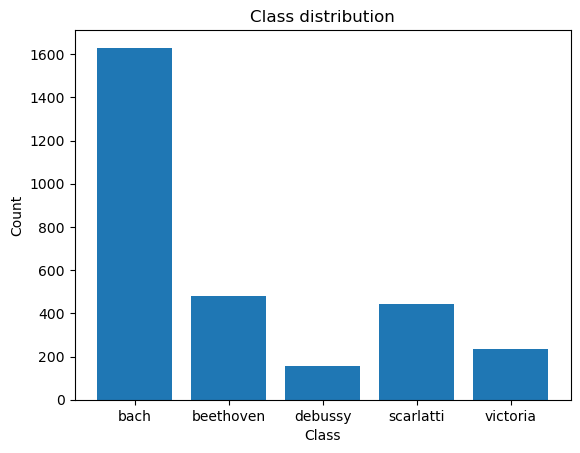

In [20]:
plt.bar(y_counts.keys(), y_counts.values())

plt.title('Class distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(range(num_classes), class_names.values())

plt.show()

The graph shows a class imbalance

# Split data to train and validation sets

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SET_FRACTION, stratify=y)

## Scaling

In [22]:
X_train_all = []
X_val_all = []

for train_sample, val_sample in zip(X_train, X_val):
    X_train_all.extend(train_sample.flatten().tolist())
    X_val_all.extend(val_sample.flatten().tolist())

In [23]:
X_mean = np.mean(X_train_all)
X_std = np.std(X_train_all)

In [24]:
def standardize(X, X_mean, X_std):
    return ((X - X_mean) / X_std)  + 2.5

In [25]:
X_train_transformed = standardize(X_train, X_mean, X_std)
X_val_transformed = standardize(X_val, X_mean, X_std)


In [26]:
X_train_trans_all = []
X_val_trans_all = []

for train_sample, val_sample in zip(X_train_transformed, X_val_transformed):
    X_train_trans_all.extend(train_sample.flatten().tolist())
    X_val_trans_all.extend(val_sample.flatten().tolist())

### Datasets

In [27]:
class VariableLenDataset(Dataset):
    def __init__(self, data: torch.Tensor, targets: torch.Tensor):
        self.data = data
        self.targets = targets
        assert len(self.data) == len(self.targets)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [28]:
X_train = pad_sequence(X_train, batch_first=True, padding_value=0)
X_val = pad_sequence(X_val, batch_first=True, padding_value=0)

In [29]:
train_dataset = VariableLenDataset(X_train, y_train)
val_dataset = VariableLenDataset(X_val, y_val)

In [30]:
print(f'Train set size: {len(train_dataset)}')
print(f'Val set size: {len(val_dataset)}')

Train set size: 2645
Val set size: 294


### DataLoaders

In [31]:
def pad_collate(batch):
    samples, targets = zip(*batch)
    samples_lengths = np.array(list(map(len, samples)))
    return pad_sequence(samples, batch_first=True, padding_value=0), samples_lengths, torch.Tensor(targets).type(torch.LongTensor).view(-1, 1)  # 

In [32]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=False, collate_fn=pad_collate)
val_dataloader = DataLoader(val_dataset, batch_size=8, drop_last=False, collate_fn=pad_collate)

# Model

In [33]:
class RNNClassificationModelTemplate(nn.Module):
    def __init__(self, num_classes, device, callbacks=None) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.device = device
        self.callbacks = callbacks
        self.train_report = {
            'train_loss_history': [],
            'val_loss_history': []
        }
        
    def init_hidden(self, batch_size):
        hidden = torch.zeros(size=(self.num_layers, batch_size, self.hidden_size), dtype=torch.float32)
        state = torch.zeros(size=(self.num_layers, batch_size, self.hidden_size), dtype=torch.float32)
        return hidden, state

    def forward(self, X, X_lengths, hidden):
        return X, hidden
    
    def predict(self, X, X_lengths, hidden):
        self.eval()
        y_pred = self.forward(X, X_lengths, hidden)
        return torch.tensor([torch.argmax(pred) for pred in y_pred])
    
    def fit(self, train_dataloader, loss_func, optimizer, epochs, val_dataloader=None):
        self.train()
        for epoch in range(epochs):
            print('================================')
            print(f'Epoch {epoch}')
            train_epoch_loss = self._train_one_epoch(train_dataloader, loss_func, optimizer)
            avg_epoch_loss = train_epoch_loss / len(train_dataloader)
            self._log_training_loss(avg_epoch_loss, epoch)
            
            if val_dataloader is not None:
                val_loss = self.perform_validation(loss_func, val_dataloader)
                avg_val_loss = val_loss / len(val_dataloader)
                self._log_validation_loss(avg_val_loss)
            
            if self.callbacks is not None:
                if self.callbacks.get['early_stopping'] is not None:
                    self.callbacks['early_stopping'](avg_epoch_loss, avg_val_loss)
                    if self.callbacks['early_stopping'].early_stop:
                        print('Stopping early')
                        break
    
    def _train_one_epoch(self, train_dataloader, loss_func, optimizer):
        epoch_loss = 0.0
        for batch_samples, batch_lengths, batch_labels in tqdm(train_dataloader):
            X = batch_samples.unsqueeze(2).to(self.device)
            y = batch_labels.to(self.device)
            
            hidden, state = self.init_hidden(X.size(0))  # new state for each sample
            hidden, state = hidden.to(self.device), state.to(self.device)
            y_pred = self.forward(X, (batch_lengths - 1), (hidden, state))     
            
            loss = loss_func(y_pred, y.squeeze())
            self._optimize_params(loss, optimizer)
            epoch_loss += loss.item()
        return epoch_loss
            
    def _optimize_params(self, loss, optimizer):
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    def perform_validation(self, loss_func, val_dataloader):
        val_loss = 0.0
        with torch.no_grad():
            for batch_samples, batch_lengths, batch_labels in val_dataloader:                
                X = batch_samples.unsqueeze(2).to(self.device)
                y = batch_labels.to(self.device)
                
                hidden, state = self.init_hidden(X.size(0))
                hidden, state = hidden.to(self.device), state.to(self.device)
                y_pred = self.forward(X, (batch_lengths - 1), (hidden, state))     
                
                loss = loss_func(y_pred, y.squeeze())
                val_loss += loss.item()
        return val_loss
    
    def _log_training_loss(self, epoch_loss, epoch):
        self.train_report['train_loss_history'].append(epoch_loss)
        print(f'Train Loss: {epoch_loss}')
    
    def _log_validation_loss(self, epoch_loss):
        self.train_report['val_loss_history'].append(epoch_loss)
        print(f'Val Loss: {epoch_loss}')
    
    def get_conf_matrix(self, dataloader):
        confusion_matrix = torch.zeros(self.num_classes, self.num_classes)
        with torch.no_grad():
            for batch_samples, batch_lengths, batch_labels in dataloader:
                X = batch_samples.unsqueeze(2).to(self.device)
                y = batch_labels.to(self.device)
                
                hidden, state = self.init_hidden(X.size(0))
                hidden, state = hidden.to(self.device), state.to(self.device)
                y_pred = self.predict(X, (batch_lengths - 1), (hidden, state)) 
                
                for t, p in zip(y.view(-1), y_pred.view(-1)):
                        confusion_matrix[t.long(), p.long()] += 1
        return confusion_matrix
    
    def class_accuracy(self, dataloader):
        conf_matrix = self.get_conf_matrix(dataloader)
        return conf_matrix.diag()/conf_matrix.sum(1)


class LSTM_Classifier(RNNClassificationModelTemplate):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, device, dropout_frac=0.4, pad_value=0, callbacks=None):
        super().__init__(num_classes, device, callbacks)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.pad_value = pad_value
        self.dropout_fac = dropout_frac
        self.dropout = nn.Dropout(0.1)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=self.dropout_fac)
        self.fc = nn.Linear(hidden_size, 64)
        self.output_layer = nn.Linear(64, num_classes)
    
    def forward(self, X, X_indicies, hidden):
        X = torch.transpose(X, 0, 1)
        out, _ = self.lstm(X, hidden)
        out_t = torch.transpose(out, 0, 1)
        cutout_X = out_t[np.arange(len(X_indicies)), X_indicies]
        
        X = self.fc(cutout_X)
#         X = self.dropout(X)
        X = self.output_layer(X)
        return X

# Training

In [34]:
early_stopping = EarlyStopping(5, 0.3)

# callbacks = {'early_stopping': early_stopping}
callbacks = None

In [35]:
model = LSTM_Classifier(input_size=1,
                        hidden_size=80, 
                        num_layers=2, 
                        num_classes=num_classes, 
                        device=device,
                        dropout_frac=0.5
                        ).to(device)

model

LSTM_Classifier(
  (dropout): Dropout(p=0.1, inplace=False)
  (lstm): LSTM(1, 80, num_layers=2, dropout=0.5)
  (fc): Linear(in_features=80, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=5, bias=True)
)

In [ ]:
class_weights = compute_class_weight(class_weight='balanced', classes=y_train.unique().numpy(), y=y_train.flatten().numpy())
class_weights = class_weights + np.array([0, 0, 0.5, 1, 0])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
class_weights

In [169]:
loss_func = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # , weight_decay=0.0001

# Training

In [170]:
model.fit(train_dataloader, loss_func, optimizer, epochs=30, val_dataloader=val_dataloader)

Epoch 0


100%|██████████| 331/331 [00:06<00:00, 55.15it/s]


Train Loss: 1.5828508668075516
Val Loss: 1.568842981312726
Epoch 1


100%|██████████| 331/331 [00:05<00:00, 56.31it/s]


Train Loss: 1.5580992043198416
Val Loss: 1.497835697354497
Epoch 2


100%|██████████| 331/331 [00:06<00:00, 55.02it/s]


Train Loss: 1.543542386902063
Val Loss: 1.430348795813483
Epoch 3


100%|██████████| 331/331 [00:05<00:00, 56.38it/s]


Train Loss: 1.465436648926346
Val Loss: 1.3919837088198275
Epoch 4


100%|██████████| 331/331 [00:05<00:00, 55.67it/s]


Train Loss: 1.3887829859811374
Val Loss: 1.379699566879788
Epoch 5


100%|██████████| 331/331 [00:05<00:00, 56.50it/s]


Train Loss: 1.3689201110439357
Val Loss: 1.2961557185327686
Epoch 6


100%|██████████| 331/331 [00:05<00:00, 56.03it/s]


Train Loss: 1.3343043012201246
Val Loss: 1.2559363890338588
Epoch 7


100%|██████████| 331/331 [00:05<00:00, 55.70it/s]


Train Loss: 1.2938511702949547
Val Loss: 1.2366841209901345
Epoch 8


100%|██████████| 331/331 [00:05<00:00, 56.73it/s]


Train Loss: 1.272792791491909
Val Loss: 1.2575989639436878
Epoch 9


100%|██████████| 331/331 [00:05<00:00, 56.81it/s]


Train Loss: 1.2261778915756778
Val Loss: 1.18535148936349
Epoch 10


100%|██████████| 331/331 [00:05<00:00, 55.82it/s]


Train Loss: 1.2341772678935636
Val Loss: 1.1636910261334599
Epoch 11


100%|██████████| 331/331 [00:05<00:00, 55.88it/s]


Train Loss: 1.1993934285244552
Val Loss: 1.145870100002031
Epoch 12


100%|██████████| 331/331 [00:05<00:00, 56.35it/s]


Train Loss: 1.1505950415602624
Val Loss: 1.1161897512706551
Epoch 13


100%|██████████| 331/331 [00:05<00:00, 56.25it/s]


Train Loss: 1.1091711008836855
Val Loss: 1.1194773759390857
Epoch 14


100%|██████████| 331/331 [00:05<00:00, 56.49it/s]


Train Loss: 1.0883906593495625
Val Loss: 1.1113625426550169
Epoch 15


100%|██████████| 331/331 [00:05<00:00, 56.79it/s]


Train Loss: 1.0483087346272886
Val Loss: 1.0502495757631354
Epoch 16


100%|██████████| 331/331 [00:05<00:00, 56.06it/s]


Train Loss: 1.0566969880344645
Val Loss: 1.113994864998637
Epoch 17


100%|██████████| 331/331 [00:05<00:00, 56.29it/s]


Train Loss: 1.0457605393631582
Val Loss: 1.0804631114006042
Epoch 18


100%|██████████| 331/331 [00:05<00:00, 56.73it/s]


Train Loss: 1.018859085854807
Val Loss: 1.0663225602459263
Epoch 19


100%|██████████| 331/331 [00:05<00:00, 55.53it/s]


Train Loss: 0.9986994148111056
Val Loss: 1.0471884914346643
Epoch 20


100%|██████████| 331/331 [00:05<00:00, 55.36it/s]


Train Loss: 0.9905025004620278
Val Loss: 1.0165605230911359
Epoch 21


100%|██████████| 331/331 [00:05<00:00, 55.64it/s]


Train Loss: 0.9578204924786559
Val Loss: 0.9717350207470559
Epoch 22


100%|██████████| 331/331 [00:05<00:00, 56.81it/s]


Train Loss: 0.9570664707627541
Val Loss: 1.0003337634576333
Epoch 23


100%|██████████| 331/331 [00:05<00:00, 57.15it/s]


Train Loss: 0.9675770973240861
Val Loss: 0.9415221294841251
Epoch 24


100%|██████████| 331/331 [00:05<00:00, 56.53it/s]


Train Loss: 0.9210046741807569
Val Loss: 0.8964129847449225
Epoch 25


100%|██████████| 331/331 [00:05<00:00, 56.47it/s]


Train Loss: 0.9071162544258412
Val Loss: 0.9588789625747783
Epoch 26


100%|██████████| 331/331 [00:05<00:00, 56.62it/s]


Train Loss: 0.9061034806635445
Val Loss: 0.927440774601859
Epoch 27


100%|██████████| 331/331 [00:05<00:00, 55.38it/s]


Train Loss: 0.8831897505820698
Val Loss: 0.9360125499802667
Epoch 28


100%|██████████| 331/331 [00:05<00:00, 55.71it/s]


Train Loss: 0.8905132827531895
Val Loss: 0.9642080725044817
Epoch 29


100%|██████████| 331/331 [00:05<00:00, 55.41it/s]


Train Loss: 0.9194793544957285
Val Loss: 0.9799935519695282


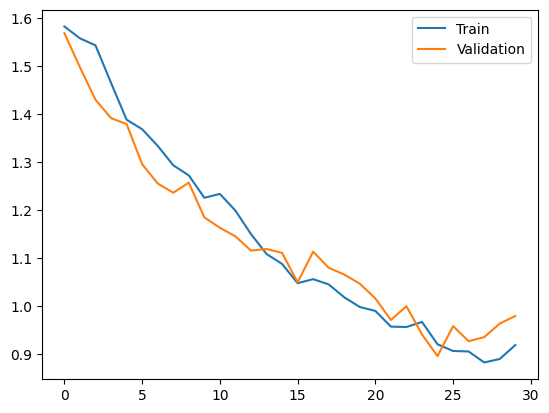

In [171]:
plt.plot(model.train_report['train_loss_history'], label='Train')
plt.plot(model.train_report['val_loss_history'], label='Validation')
plt.legend()
plt.savefig('train.png')

plt.show()


# Validation

### Accuracy per class

In [172]:
train_acc_per_class = model.class_accuracy(train_dataloader)
val_acc_per_class = model.class_accuracy(val_dataloader)


In [173]:
print(f'Train class acc: {train_acc_per_class}')
print(f'Val class acc: {val_acc_per_class}')

Train class acc: tensor([0.3783, 0.5372, 0.4676, 0.8463, 0.8774])
Val class acc: tensor([0.3067, 0.5833, 0.3333, 0.7727, 0.7917])


In [174]:
print(f'Train acc: {torch.mean(train_acc_per_class)}')
print(f'Val acc: {torch.mean(val_acc_per_class)}')

Train acc: 0.6213728785514832
Val acc: 0.5575617551803589


## Model saving

In [121]:
torch.save(model.state_dict(), 'model_val66_train84.pt')

### Loading model

In [178]:
model = LSTM_Classifier(input_size=1,
                        hidden_size=80, 
                        num_layers=2, 
                        num_classes=num_classes, 
                        device=device,
                        dropout_frac=0.5
                        ).to(device)

model.load_state_dict(torch.load('model_val66_train84.pt'))
model

LSTM_Classifier(
  (dropout): Dropout(p=0.1, inplace=False)
  (lstm): LSTM(1, 80, num_layers=2, dropout=0.5)
  (fc): Linear(in_features=80, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=5, bias=True)
)

# Testing

In [183]:
class TestVariableLenDataset(Dataset):
    def __init__(self, data: torch.Tensor):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [184]:
def pad_collate_test(batch):
    samples = batch
    samples_lengths = np.array(list(map(len, samples)))
    return pad_sequence(samples, batch_first=True, padding_value=0), samples_lengths

In [185]:
def predict_for_test_dataset(test_dataset, test_dataloader, model):
    with torch.no_grad():
        predictions = []
        for batch_samples, X_lengths in test_dataloader:
            X = batch_samples.unsqueeze(2).to(model.device)
                
            hidden, state = model.init_hidden(X.size(0))
            hidden, state = hidden.to(model.device), state.to(model.device)
            y_pred = model.predict(X, (X_lengths - 1), (hidden, state)) 
            predictions.append(y_pred)
        predictions_flat = [prediction.item() for sublist in predictions for prediction in sublist]
    return predictions_flat

In [7]:
with open(test_data_opath, 'rb') as pickle_file:
    test_data = np.array(pickle.load(pickle_file), dtype=object)
    
X_test = []

for sample in samples: # powinno być 'in test_data'
    X_test.append(torch.from_numpy(sample).type(torch.float32))

In [187]:
test_dataset = TestVariableLenDataset(X_test)
test_dataloader = DataLoader(test_dataset , batch_size=8, shuffle=False, drop_last=False, collate_fn=pad_collate_test)

In [188]:
predictions = predict_for_test_dataset(test_dataset, test_dataloader, model)